# Community Detection Algorithms

We apply three distinct algorithms to detect community structures within the network. These methods rely on different mathematical definitions of what constitutes a "community".

### Louvain Algorithm: 
The Louvain method is a heuristic algorithm based on Modularity Optimization. It is a greedy, iterative method that works in two phases:
1. Local Moving: Nodes are moved to neighbor communities if the move increases the graph's modularity ($Q$)
2. Aggregation: The graph is rebuilt where communities become single "super-nodes," and edge weights are summed. This process repeats until modularity no longer increases.

<cite>
Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of statistical mechanics: theory and experiment, 2008(10), P10008.
</cite>

Documentation for the implementations used in this notebook: [NetworkX Louvain](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html)

### Leiden Algorithm
The Leiden algorithm is an improvement upon Louvain. It addresses the issue of disconnected communities and generally yields partitions with higher quality. It introduces a refinement phase between the moving and aggregation steps:
1. Local Moving: Similar to Louvain (fast modularity optimization).
2. Refinement: Communities are locally split to ensure they are well-connected.
3. Aggregation: The network is aggregated based on the refined partition.

<cite>
Traag, V. A., Waltman, L., & Van Eck, N. J. (2019). From Louvain to Leiden: guaranteeing well-connected communities. Scientific reports, 9(1), 1-12.
</cite>

Documentation for the implementations used in this notebook: [leidenalg](https://leidenalg.readthedocs.io/en/stable/reference.html)

### Spectral Clustering
Spectral Clustering uses the eigenvalues (spectrum) of the graph's Laplacian matrix to perform dimensionality reduction before clustering.
1. Construct the Laplacian matrix from the graph's adjacency matrix.
2. Compute the first $k$ eigenvectors to embed the nodes into a lower-dimensional space.
3. Apply a standard clustering algorithm (like K-Means) on these vectors to separate the nodes. Unlike Louvain/Leiden which optimize density, Spectral Clustering approximates the Min-Cut problem (minimizing the number of edges cut to separate the graph).

Documentation for the implementations used in this notebook: [sklearn SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

<cite>
Ng, A., Jordan, M., & Weiss, Y. (2001). On spectral clustering: Analysis and an algorithm. Advances in neural information processing systems, 14.
</cite>

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import SpectralClustering
from collections import defaultdict
import time
import warnings
warnings.filterwarnings('ignore')

from utils import (
    load_email, run_leiden,
    metric_avg_conductance, metric_internal_density, metric_coverage, metric_ari,
    visualize_static_entire_graph, visualize_communities, optimize_community_detection,
    get_best_granular_model
)

%load_ext autoreload
%autoreload 2

In [2]:
G = load_email(directed=False)
gt = nx.get_node_attributes(G, 'ground_truth')

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Is Directed: {G.is_directed()}")

Nodes: 986
Edges: 16064
Is Directed: False


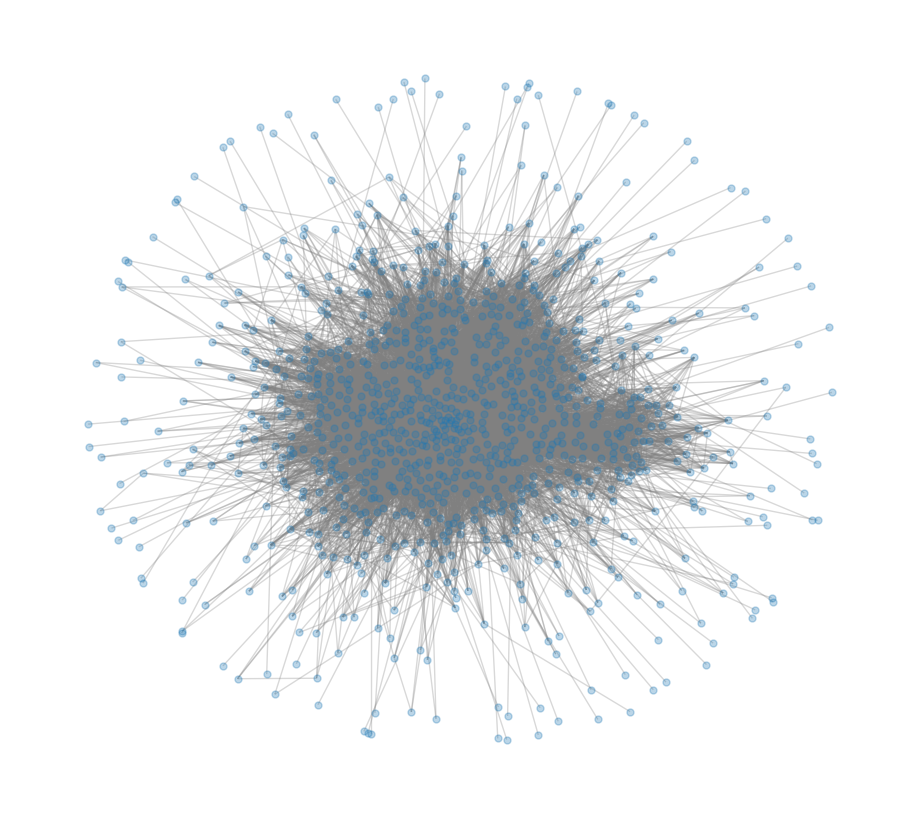

In [3]:
visualize_static_entire_graph(G, node_size= 25)

# Measures of Community Quality

To evaluate the quality of the detected communities, we utilize a combination of unsupervised metrics (structural quality) and supervised metrics (comparison to ground truth).

### Average Internal Density

This metric measures how "clique-like" the communities are. It calculates the density for each detected community and returns the average. The density of a subgraph is the ratio of actual edges to the number of possible edges.

For a community with $n$ nodes and $m$ edges: $Density = \frac{2m}{n(n-1)}$

Interpretation:
- High Value ($\to 1.0$): Nodes within the community are tightly interconnected. A value of 1.0 indicates a "Complete Graph" (everyone is connected to everyone).
- Low Value ($\to 0.0$): The community is sparse and loosely connected.

### Coverage

Coverage measures the fraction of the graph's total edges that fall within the communities, rather than cutting across them. It quantifies how "self-contained" the partition is.

We sum the number of edges inside all communities ($E_{in}$) and divide by the total edges in the entire graph ($E_{total}$): $Coverage = \frac{E_{in}}{E_{total}}$

Interpretation:
- High Value ($\to 1.0$): The partition successfully captures most edges within communities; few edges between groups.
- Low Value ($\to 0.0$): Many edges connect different communities, which hint at a weak community structure.

### Average Conductance

Conductance measures the "separability" or "isolation" of a community. It measures the ratio of edges that point outside the community versus the total connectivity (volume) of the community.

For a given set of nodes $S$, conductance is the fraction of total edge volume that leaves $S$. We calculate this for every community and take the average:

$\phi(S) = \frac{\text{Cut}(S)}{\min(\text{Vol}(S), \text{Vol}(\bar{S}))}$
- Cut(S): Number of edges leaving the community.
- Vol(S): Sum of degrees of nodes inside the community.

Interpretation:
- Low Value ($\to 0.0$): Good. The community is a distinct "island" with very few connections to the rest of the network.
- High Value ($\to 1.0$): Bad. The community is "leaky" and blends quite a bit into the rest of the graph.

### Adjusted Rand Index (ARI)

**Note: Ground Truth only exists for this dataset, and it is not present in the Twitch dataset.**

The ARI is a similarity measure between two data clusterings. Unlike standard accuracy, ARI is designed specifically for clustering tasks where the specific label values (e.g., "Group 0" vs. "Group 1") do not matter, only the grouping structure does.

- Permutation Invariance: In clustering, the algorithm might label a department as "Community 5" while the ground truth labels it "Department A." Standard accuracy would mark this as an error. ARI ignores the specific labels and asks: "If node A and node B are in the same group in the Ground Truth, are they also in the same group in the Prediction?"

- Adjustment for Chance: The raw Rand Index (RI) simply counts the fraction of correct pair agreements. However, the RI means that random assignments have a score greater than zero, which makes comparison difficult. The Adjusted RI corrects this by subtracting the expected score of a random partition.

$$ARI = \frac{RI - \text{Expected\_RI}}{\max(RI) - \text{Expected\_RI}}$$

- We use the [sklearn adjusted_rand_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) implementation.

Interpretation:
- $1.0$: Perfect match (The partitions are identical up to a permutation of labels).
- $0.0$: The result is exactly what you would expect from random chance.
- $< 0.0$: The result is worse than random.

## Experimental Setup

To objectively compare community detection algorithms, we implemented a parameter grid search that optimizes for structural integrity rather than the algorithm's own objective function (e.g., Modularity). This prevents circular reasoning where an algorithm is "best" simply because it maximizes the metric it was designed to optimize.

### Composite Structural Score

We define a custom Composite Score to rank partitions. This score balances separation (how isolated communities are) with cohesion (how connected members are).

$\text{Composite Score} = 0.4 \times (1 - \text{Conductance}) + 0.3 \times \text{Density} + 0.3 \times \text{Coverage}$

The metrics are as follows
1. Avg Conductance (Lower is better): Measures the "leakiness" of communities (fraction of edges leaving the set). We invert this ($1 - C$) so that higher values contribute positively.
2. Avg Internal Density (Higher is better): Measures how tightly connected the nodes are within a community.
3. Coverage (Higher is better): The fraction of total graph edges that exist within the detected communities.

### Grid Search

We iterate through a range of hyperparameters for each algorithm:
- Louvain & Leiden: Resolution Parameter ($0.2$ to $5.0$).
- Spectral Clustering: Number of Clusters $k$ ($5$ to $65$).

Selection vs. Validation:
- Selection: The "Best" model is selected purely based on the unsupervised Composite Score.
- Validation: We calculate the Adjusted Rand Index (ARI) against the Ground Truth (Departments) for the selected model.

In [4]:
# Hyperparameters
resolutions = np.linspace(0.2, 5.0, 20)
k_values = range(5, 65, 5)

# Optimization
df_leiden = optimize_community_detection(G, "leiden", resolutions, gt)
df_louvain = optimize_community_detection(G, "louvain", resolutions, gt)
df_spectral = optimize_community_detection(G, "spectral", k_values, gt)

--- Optimizing leiden ---
leiden finished in 2.00 seconds.
--- Optimizing louvain ---
louvain finished in 5.26 seconds.
--- Optimizing spectral ---
spectral finished in 2.91 seconds.


### Hyperparameter Ranges

- Left Panel (Resolution Optimization):
    - Compares Leiden (Green) and Louvain (Blue) across resolution parameters ranging from $0.2$ to $5.0$.
    - The peak of the curve represents the "structural sweet spot" where the community definitions are most mathematically robust.
    - A sharp drop-off typically indicates over-fragmentation (shattering communities) or under-segmentation (giant blobs).

- Right Panel (Cluster Count Optimization):
    - Evaluates Spectral Clustering by forcing the algorithm to find $k$ partitions ($5$ to $65$).
    - The Red Dotted Line at $k=42$ represents the Ground Truth (the actual number of departments).
    - Interpretation: Ideally, the peak of the composite score (Purple square) should align with the red line. **This shows a conflict between the graph's topology (math) and its labels (reality).**

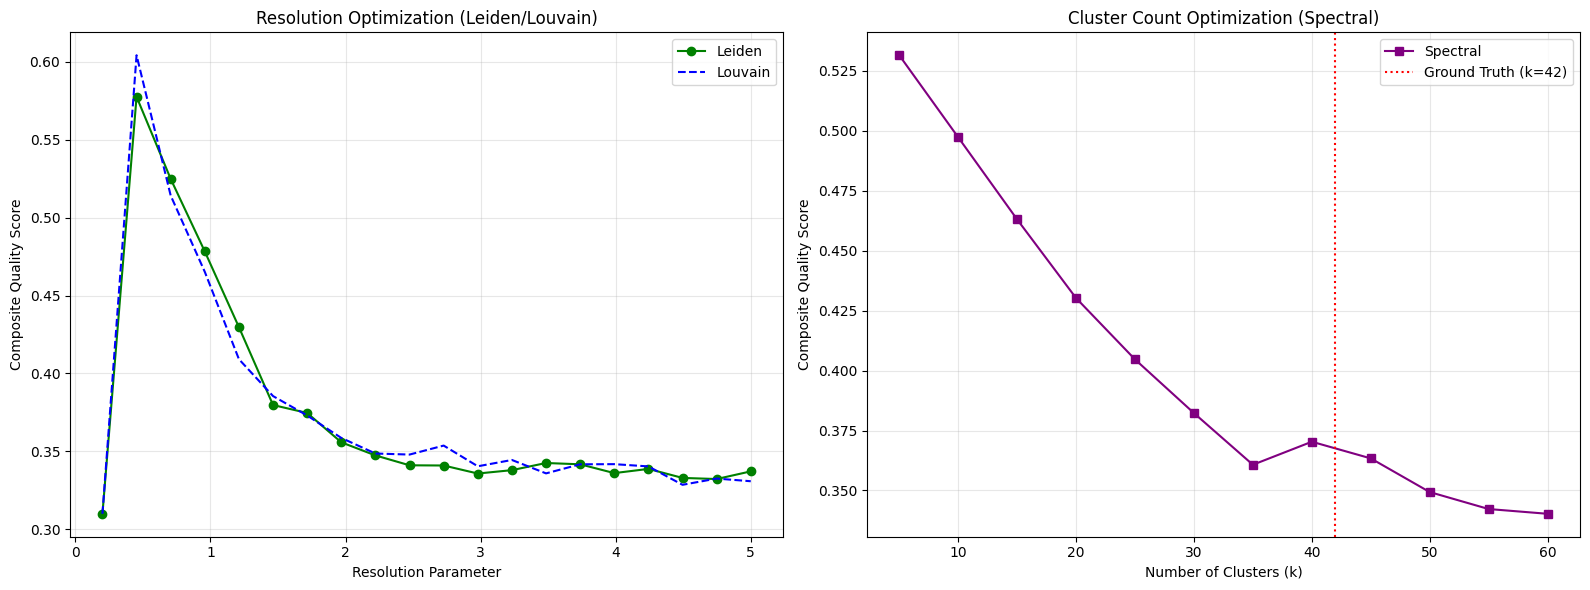

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Resolution Optimization
ax1.plot(df_leiden['Param'], df_leiden['Composite_Score'], label='Leiden', color='green', marker='o')
ax1.plot(df_louvain['Param'], df_louvain['Composite_Score'], label='Louvain', color='blue', linestyle='--')
ax1.set_title("Resolution Optimization (Leiden/Louvain)")
ax1.set_xlabel("Resolution Parameter")
ax1.set_ylabel("Composite Quality Score")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: K Optimization
ax2.plot(df_spectral['Param'], df_spectral['Composite_Score'], label='Spectral', color='purple', marker='s')
ax2.axvline(x=42, color='red', linestyle=':', label='Ground Truth (k=42)')
ax2.set_title("Cluster Count Optimization (Spectral)")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Composite Quality Score")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Min 5 Communities

To avoid trivial partitions (e.g., 2 giant communities), we filter out results with fewer than 5 detected communities when selecting the best model.

Mathematically, the algorithms maximize structural quality (Composite Score $\approx 0.53$) by partitioning the graph into 6 large communities. While these partitions are structurally robust (low Conductance), the low ARI ($\approx 0.20$) indicates they represent larger organizational divisions rather than specific departments.

In [6]:
best_leiden = get_best_granular_model(df_leiden, min_communities=5)
best_louvain = get_best_granular_model(df_louvain, min_communities=5)
best_spectral = get_best_granular_model(df_spectral, min_communities=5)

# combine
summary_df = pd.DataFrame([best_leiden, best_louvain, best_spectral])
summary_df.set_index("Algorithm", inplace=True)

display_cols = ["Param", "Communities", "Composite_Score", "ARI", "Conductance", "Density", "Coverage"]
final_view = summary_df[display_cols]

styled_table = final_view.style.background_gradient(
    cmap='Greens', subset=["Composite_Score", "ARI", "Density", "Coverage"]
).background_gradient(
    cmap='Greens_r', subset=["Conductance"] # Low is good
).format("{:.4f}")

print("\nBest Granular Configurations (min 5 communities)")
display(styled_table)


Best Granular Configurations (min 5 communities)


,Param,Communities,Composite_Score,ARI,Conductance,Density,Coverage
Algorithm,,,,,,,
Leiden,0.7053,6.0000,0.5249,0.2068,0.3426,0.2057,0.6673
Louvain,0.7053,6.0000,0.5142,0.2004,0.3456,0.1738,0.6675
Spectral,5.0000,5.0000,0.5315,0.0990,0.3533,0.1394,0.7700


Detected 6 communities using Leiden with resolution 0.7053.

=== COMMUNITY STATISTICS (EMAIL) ===
community       | num_nodes      
---------------------------------
0               | 361            
1               | 243            
2               | 144            
3               | 113            
4               | 93             
5               | 32             


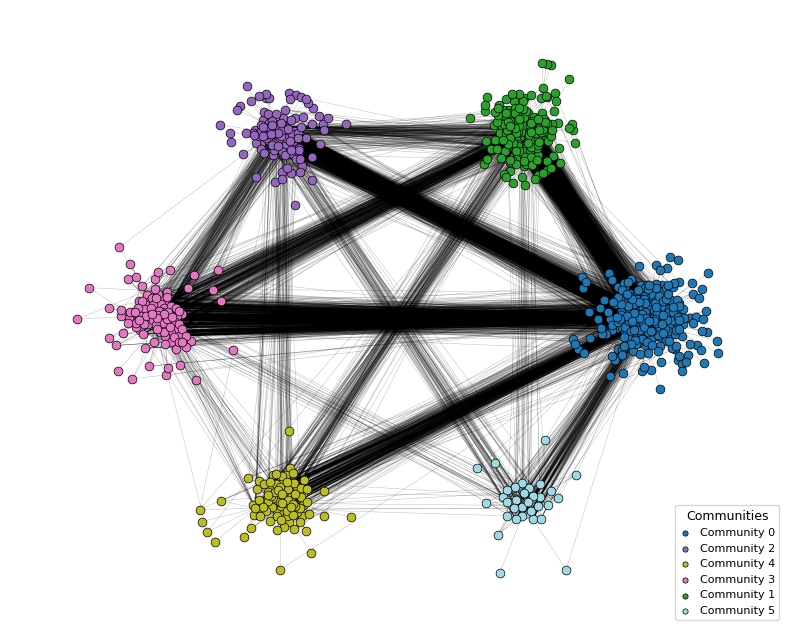

In [7]:
visualize_communities(G, method="leiden", resolution=0.7053, dataset_name="email")

#### **Insights of Leiden Communities**

**The case of 6 Super-Communities (above)**

Mathematically, the algorithms prefer this coarse-grained partition. The Composite Scores here ($\approx 0.52$) are significantly higher than in the granular configuration ($\approx 0.35$). This indicates that the network's strongest structural boundaries form 6 large "Super-Communities" (likely Divisions or Directorates) rather than 42 small departments.Both Leiden and Louvain converged on Resolution $0.7053$, finding 6 communities. While structurally stable (Conductance $\approx 0.34$), the low ARI ($\approx 0.20$) confirms that these super-groups are too broad to represent specific departments.

**The case of 51 Communities (below)**

Leiden proved to be the most accurate algorithm for this specific dataset, achieving the highest ARI (0.62) and finding 51 communities. This slight over-segmentation (51 vs 42) suggests that Leiden not only found the departments but potentially identified distinct sub-teams within larger departments.

Leiden's superiority over Louvain here is likely due to its Refinement Phase. While Louvain merged collaborating departments, Leiden successfully recognized them as separate dense structures and split them. It essentially prioritized "clique strictness" over general connectivity. This makes more sense for organizational structures, where distinct teams exist even if they collaborate a lot.

**Metrics Leiden**
The metrics for Leiden are very similar to Louvain but slightly more extreme in the "Micro" direction.
- Density (0.486): Higher than Louvain. Leiden found tighter internal structures.
- Conductance (0.79): Slightly higher (more leaky) than Louvain.
- Interpretation: The fact that Leiden has higher density and higher conductance confirms that it went deeper into the graph's structure. It found the absolute core of each department. It accepted a messier boundary (higher conductance) to make sure that the internal structure of the community was mathematically perfect (higher density). This is why it achieved the highest match with the Ground Truth out of the three algorithms.

Detected 6 communities using Louvain with resolution 0.7053.

=== COMMUNITY STATISTICS (EMAIL) ===
community       | num_nodes      
---------------------------------
0               | 237            
1               | 92             
2               | 111            
3               | 51             
4               | 377            
5               | 118            


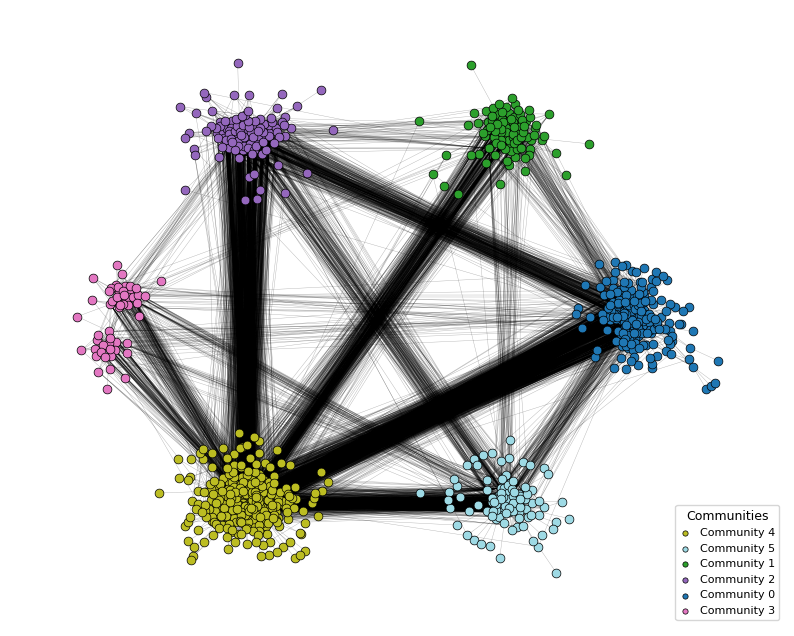

In [8]:
visualize_communities(G, method="louvain", resolution=0.7053, dataset_name="email")

#### **Insights of Louvain Communities**

**The case of 45 Communities (below)**

Louvain successfully transitioned from finding divisions to finding departments when the resolution was increased ($3.23$, see the parameters below).

The high ARI (0.60) confirms that Louvain correctly identified that departments are formed by internal density (cliques of colleagues emailing each other). However, it found fewer communities than Leiden (45 vs 51). This is a known behavior of Louvain: it tends to merge distinct but interacting communities into larger groups. In the context of this email network, Louvain likely merged two closely collaborating departments into a single community because the volume of emails between them was high enough to trick the algorithm.

**Metrics Louvain**

At the granular level **(Min 40)**, the metrics tell a clear story of "High Density, High Leakage."

- Density (0.47): This is high. It proves that inside the communities Louvain found, connectivity is very strong.
- Conductance (0.78): This is technically "bad" (high leakage), but in this context, it is necessary. It reflects the reality that employees constantly email people outside their department.
- Trade-off: To achieve the high ARI (finding the departments), Louvain had to sacrifice separation (Conductance). This confirms that the "natural" mathematical state of the graph is closer to 6 big blobs as you can see above, and finding the departments required forcing the algorithm against the natural gradient of the graph.

  File "c:\Users\Kristof\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Kristof\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kristof\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Kristof\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



=== COMMUNITY STATISTICS (EMAIL) ===
community       | num_nodes      
---------------------------------
0               | 66             
1               | 38             
2               | 25             
3               | 53             
4               | 804            


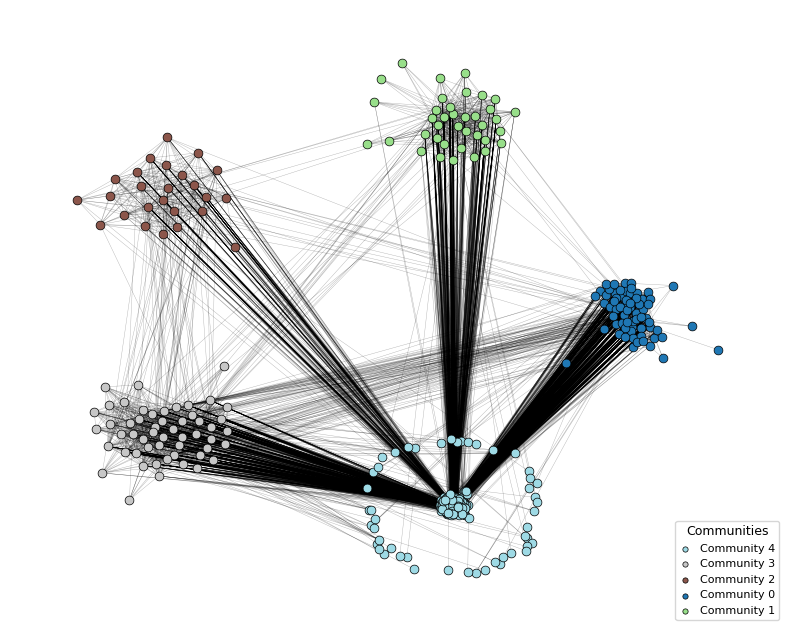

In [9]:
visualize_communities(G, method="spectral", k=5, dataset_name="email", n_neighbors=20)

#### **Insights Spectral**

**The case of 5 Clusters (above)**

Spectral Clustering has a strong preference for the Macro-Structure over the Ground Truth. At $k=5$, it achieved the highest Composite Score (0.53) but the lowest ARI (0.09). This means that Spectral identified mathematically sharp "cuts" in the network (likely separating the largest organizational divisions), but these cuts had almost no correlation with actual departments.

**The case of 40 clusters (below)**

Even when forced to find 40 clusters (matching the approximate number of departments, you can see that below), Spectral underperformed compared to density-based methods (ARI 0.43 vs 0.62). This suggests that departments in this organization are not defined by "bottlenecks" (which Spectral looks for). There is likely too much inter-departmental communication for a Min-Cut approach to work properly; instead of identifying actual departments, Spectral likely prioritized separating small, outlying groups, forcing it to make random cuts through the dense center of the network.

### Min 40 Communities

By forcing a finer granularity, the Composite Score drops ($\approx 0.34$), meaning that the specific departments are more interconnected ("leakier") than the divisions. However, the ARI increases by a lot ($\approx 0.62$), confirming that the Ground Truth ($k=42$) exists at this lower scale (which is less optimal structurally).

In [10]:
best_leiden = get_best_granular_model(df_leiden, min_communities=40)
best_louvain = get_best_granular_model(df_louvain, min_communities=40)
best_spectral = get_best_granular_model(df_spectral, min_communities=40)

# combine
summary_df = pd.DataFrame([best_leiden, best_louvain, best_spectral])
summary_df.set_index("Algorithm", inplace=True)

display_cols = ["Param", "Communities", "Composite_Score", "ARI", "Conductance", "Density", "Coverage"]
final_view = summary_df[display_cols]

styled_table = final_view.style.background_gradient(
    cmap='Greens', subset=["Composite_Score", "ARI", "Density", "Coverage"]
).background_gradient(
    cmap='Greens_r', subset=["Conductance"] # Low is good
).format("{:.4f}")

print("\nBest Granular Configurations (min 40 communities)")
display(styled_table)


Best Granular Configurations (min 40 communities)


,Param,Communities,Composite_Score,ARI,Conductance,Density,Coverage
Algorithm,,,,,,,
Leiden,3.4842,51.0000,0.3425,0.6232,0.7928,0.4859,0.3795
Louvain,3.2316,45.0000,0.3445,0.6082,0.7844,0.4699,0.3909
Spectral,40.0000,40.0000,0.3703,0.4373,0.6900,0.4152,0.4059


### Algorithm Performance

- Leiden outperformed all models at the micro-scale (ARI $0.62$ vs Spectral $0.43$). This means that the departmental structure is defined by internal density (cliques of colleagues), which Leiden optimizes better, rather than by min-cuts, which Spectral attempts to find.
- Spectral Limitation: Even when forced to find $k=40$ clusters, Spectral Clustering achieved a significantly lower ARI. This suggests that the "cuts" required to isolate departments are not geometrically distinct in the eigenvector space, likely due to high edge overlap bewteen departments.